In [7]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression, LinearRegression

from joblib import Parallel, delayed

sns.set(font_scale=1.3, palette='Set2', style='whitegrid')

На основе материалов <a href="https://matheusfacure.github.io/python-causality-handbook/landing-page.html">учебника</a>.

## 1. Propensity Score

Рассмотрим [данные](https://github.com/matheusfacure/python-causality-handbook/blob/c817a34e69ef96d2344064f01eeccc129ab365ca/causal-inference-for-the-brave-and-true/data/learning_mindset.csv) об исследовании семинаров о Growth Mindset (установка на рост). Это рандомизированное исследование, проведенное в государственных школах США, целью которого является выявление влияния специальных семинаров Growth Mindset. После прохождения семинаров исследователи наблюдают за студентами во время учебы в колледже. Реальные данные по этому исследованию не являются общедоступными для сохранения конфиденциальности. Будем работать с искусственным набором данных с теми же статистическими свойствами.


Признаки

* `schoolid` &mdash; идентификатор школы учащегося;

* `intervention` &mdash; назначен ли ученику специальный семинар;

* `achievement_score` &mdash; успешность ученика, стандартизированный признак;

* `success_expect` &mdash; самооценка успеха в будущем, показатель предыдущих достижений, измеренный до случайного тритмента;

* `ethnicity` &mdash; этническая принадлежность студента, категориальный признак;

* `gender` &mdash; пол ученика, категориальный признак;

* `frst_in_family` &mdash; первый ли в семье, поступивший в колледж, категориальный признак;

* `school_urbanicity` &mdash; уровень урбанизации школы (сельская, пригородная и т.д.), категориальный признак;

* `school_mindset` &mdash; среднее значение типа мышления учащихся на уровне школы, зафиксированное до эксперимента, стандартизированный признак;

* `school_achievement` &mdash; уровень школьных достижений, измеряемый результатами тестов и подготовкой к колледжу для предыдущих 4 групп учащихся, стандартизированный признак;

* `school_ethnic_minority` &mdash; этнический состав школы, т.е. процент чернокожих, латиноамериканцев или коренных американцев среди учащихся, стандартизированный признак;

* `school_poverty` &mdash; концентрация бедности в школе, т.е. процент учащихся из семей, доходы которых ниже черты бедности, стандартизированный признак;

* `school_size` &mdash; общее количество учащихся во всех четырех классах школы, стандартизированный признак.

In [8]:
data = pd.read_csv("https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/c817a34e69ef96d2344064f01eeccc129ab365ca/causal-inference-for-the-brave-and-true/data/learning_mindset.csv")
data.sample(5)

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
4903,64,0,-0.312475,6,4,2,1,2,-0.354207,1.264388,-0.819529,-1.158360,0.810117
8379,21,0,1.187359,5,5,2,1,4,1.235106,-0.699595,-0.006243,0.263063,-0.582541
6903,41,0,-0.208974,5,2,2,1,1,1.266067,-1.037368,1.463136,0.700118,-1.526880
2502,19,1,0.845148,6,4,1,0,4,-0.709925,-0.516239,-0.987767,-0.159602,0.262221
765,62,1,0.198874,5,4,1,0,4,-1.132241,0.726836,-0.057036,1.330512,1.892348


Хотя исследование было рандомизированным, не похоже на отсутствие смещения в данных. Дело в том, что возможность принять участие была случайной, но само участие таковым не является. Например, мы можем видеть, что студенты с более высокой самооценкой (до начала эксперимента) с большей вероятностью присоединились к семинару.

In [9]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

Тем не менее, посмотрим на разность средних $\mathsf{E}(Y|T=1) - \mathsf{E}(Y|T=0)$, будем рассматривать ее как бейзлайн

In [10]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


Видим, что у посещающих семинар оценка достижений в среднем на $0,3185 = 0,4723 - 0,1538$ выше среднего балл, который равен нулю, поскольку оценка стандартизирована.

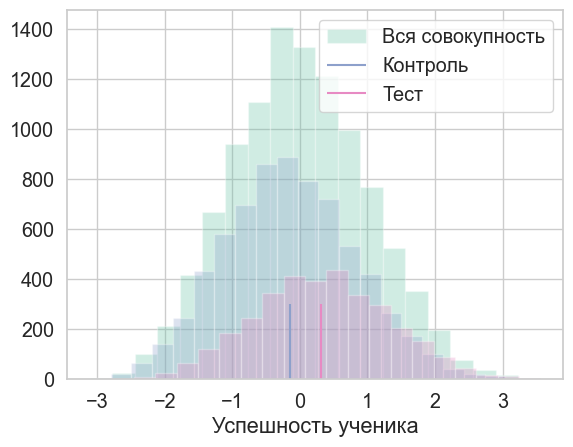

In [11]:
plt.hist(
    data["achievement_score"],
    bins=20, alpha=0.3, label="Вся совокупность"
)
plt.hist(
    data.query("intervention==0")["achievement_score"],
    bins=20, alpha=0.3, color="C2"
)
plt.hist(
    data.query("intervention==1")["achievement_score"],
    bins=20, alpha=0.3, color="C3"
)
plt.vlines(-0.1538, 0, 300, label="Контроль", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Тест", color="C3")
plt.xlabel("Успешность ученика")
plt.legend()
plt.show();

### 1.1 Непосредственно Propensity score

Идея: нет необходимости напрямую в модели контролировать все конфаундеры $X$ для достижения условной независимости $(С_1, С_0){\perp\!\!\!\perp} T | X$. Вместо этого достаточно контролировать условное мат. ожидание $\mathsf{E}(T|X)$ как случайную величины. Если тритмент бинарный, то он является условной вероятностью тритмента $\mathsf{P}(T=1|X)$, также называемый **propensity score** $P(x) = \mathsf{P}(T=1|X=x)$.

Propensity score позволяет не ставить условие на весь $X$ для получения независимости. Достаточно поставить условие только на propensity score
$$(C_1, C_0) \perp T | P(X)$$

Propensity score &mdash; это условная вероятность тритмента, по сути это функция, которая преобразует признаки $X$ в тритмент $T$. В ней сосредоточена вся информация о том, как признаки $X$ влияют на $T$. Все остальное &mdash; непрогнозируемый шум. Если мы фиксируем $P(X)$, то сам $X$ ничего не говорит о том, каким может быть $T$.

Посмотрим, как будет выглядеть наш граф.

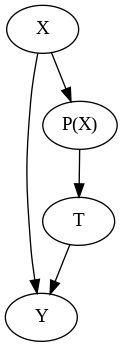

Посещающие семинар и не посещающие изначально несопоставимы, потому что у более амбициозных людей больше вероятность пройти семинар и достичь большего в жизни. Однако, если взять два студента из разных групп, но *с одинаковой вероятностью тритмента*, они будут сопоставимы. А единственная причина, по которой один из них посещал семинар, а другой нет &mdash; это чистая случайность. Фиксация propensity score приводит к тому, что данные выглядят подобно случайным.

---

Покажем, что условие $(C_1, C_0) {\perp\!\!\!\perp} T | P(X)$ эквивалентно $\mathsf{E}(T|P(X), X) = \mathsf{E}(T|P(X))$
Иначе говоря, при рассмотрении $P (X)$ в условии, сам $X$ не дает никакой дополнительной информации о $T$.

Доказательство:
* Левая часть
$$\mathsf{E}(T|P(X), X) = \mathsf{E}(T|X) = P(X)$$

* Правая часть
$$\mathsf{E}(T|P(X)) = \mathsf{E}( \ \mathsf{E}(T|P(X), X) \  |P(X)) = \mathsf{E}( P(X)  |P(X)) = P(X)$$


### 1.2 Propensity Weighting

После получения propensity score можно использовать оценку, которая зависит только от него, а не от всех признаков $X$.

Идея следующая
$$\mathsf{E}(Y|X,T=1)−\mathsf{E}(Y|X,T=0) = \mathsf{E}\bigg[\left.\dfrac{Y}{P(X)}\right|X,T=1\bigg]P(X) - \mathsf{E}\bigg[\left.\dfrac{Y}{1-P(X)}\right|X,T=0\bigg](1-P(X))$$


Первое слагаемое берет всех тех, кто в тестовой группе, и масштабирует их по обратной вероятности попасть в тестовую группу. Тем самым люди с очень низкой вероятностью тритмента имеют высокий вес. Смысл в том, что если у кого-то низкая вероятность тритмента, то этот человек выглядит как представитель контрольной группы. Однако этот человек был в тестовой группе. Тем самым логично придать ему высокий вес. Это создает популяцию того же размера, что и исходная совокупность данных, но в которой тритмент оказывает влияние на всех.

Аналогично второе слагаемое взаимодействует с контрольной группой, придавая высокий вес тем, которые выглядят так, как будто они в тестовой группе.


Можем также унифицировать эти условные мат. ожидания:

$$\mathsf{E}\bigg[Y \dfrac{T-P(X)}{P(X)(1-P(X))}\bigg|X, T\bigg]$$

Далее, беря мат. ожидание по $T$, получаем

$$\mathsf{E}\bigg[Y \dfrac{T-P(X)}{P(X)(1-P(X))}\bigg|X\bigg]$$

Обратите внимание, что $P(X)$ и $1-P(X)$ должны быть больше нуля. Это означает, что у каждого должен быть хотя бы какой-то шанс получить тритмент или не получить его. Иначе говоря, распределения должны пересекаться. Иначе они будут очень разными, не получится надежно экстраполировать эффект одной группы на другую.

## 2. Propensity Score Estimation


В идеальном мире у нас был бы истинный $P(x)$. Но в реальности мы можем получить только его оценку $\widehat{P}(x)$. Наиболее распространенный способ &mdash; логистическая регрессия.

Подготовим данные

In [12]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = [
    "school_mindset", "school_achievement",
    "school_ethnic_minority", "school_poverty", "school_size"
]

data_with_categ = pd.concat([
    # вещественные признаки
    data.drop(columns=categ),
    # преобразование категориальных признаков
    pd.get_dummies(data[categ], columns=categ, drop_first=False)
], axis=1)

print(data_with_categ.shape)

(10391, 32)


In [13]:
data_with_categ.drop(['intervention'],axis = 1).columns

Index(['schoolid', 'achievement_score', 'success_expect', 'frst_in_family',
       'school_mindset', 'school_achievement', 'school_ethnic_minority',
       'school_poverty', 'school_size', 'ethnicity_1', 'ethnicity_2',
       'ethnicity_3', 'ethnicity_4', 'ethnicity_5', 'ethnicity_6',
       'ethnicity_7', 'ethnicity_8', 'ethnicity_9', 'ethnicity_10',
       'ethnicity_11', 'ethnicity_12', 'ethnicity_13', 'ethnicity_14',
       'ethnicity_15', 'gender_1', 'gender_2', 'school_urbanicity_0',
       'school_urbanicity_1', 'school_urbanicity_2', 'school_urbanicity_3',
       'school_urbanicity_4'],
      dtype='object')

In [14]:
def calculate_ps(df, X, T):
    '''
    Обучает логистическую регрессию для оценки propensity_score

    df : pd.DataFrame
        данные
    X : pd.DataFrame.columns
        список признаков
    T : str
        признак-тритмент
    '''
    logreg = LogisticRegression().fit(df[X],df[T])
    return logreg.predict_proba(df[X])
    pass

Оценим propensity score с помощью лог регрессии

In [15]:
probs = calculate_ps(data_with_categ, data_with_categ.drop(['intervention'],axis = 1).columns, 'intervention').T[0]

In [16]:
probs

array([0.65693948, 0.73682724, 0.58171236, ..., 0.58093598, 0.73227771,
       0.66218444])

Убедимся, что propensity score действительно воссоздает популяцию, в которой на всех оказывается влияние, и наоборот.

In [17]:
print("Размер исходной выборки:", data.shape[0])
print("Размер раздутой тестовой выборки:", (probs[probs < 0.5]**(-1)).sum())
print("Размер раздутой контрольной выборки:", (probs[probs >= 0.5]**(-1)).sum())

Размер исходной выборки: 10391
Размер раздутой тестовой выборки: 1744.9431428747366
Размер раздутой контрольной выборки: 14152.868278543901



Можно также использовать propensity score, чтобы увидеть смещение. Если сегментация учеников по уровню самооценки имеет разный propensity score, это означает, что тритмент не является рандомным. Если эта же величина влияет и на таргет, получаем случай парадокса Симпсона


Постройте boxplot, демонстрирующий распределение propensity score в зависимости от самооценки студента.

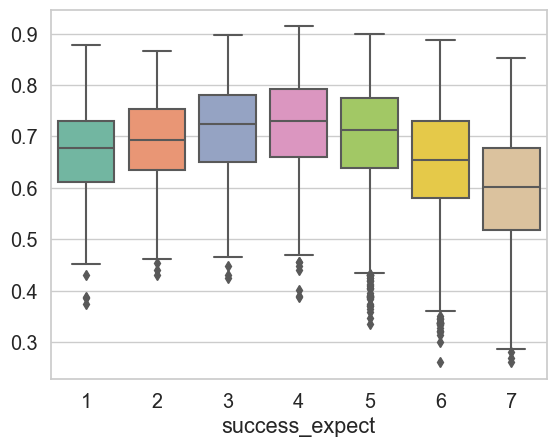

In [18]:
sns.boxplot(x = data_with_categ['success_expect'], y = probs)
plt.show()

Также необходимо проверить, есть ли пересечение между тестом и контролем. Для этого можно построить гистограмму propensity score по двум группам.

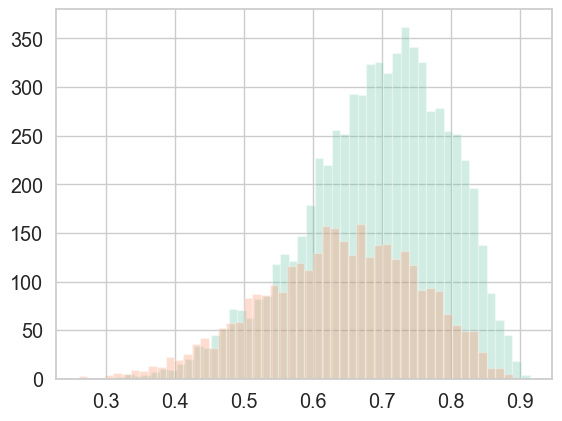

In [19]:
plt.hist(probs[data['intervention'] == 0], bins = 50, alpha = 0.3)
plt.hist(probs[data['intervention'] == 1], bins = 50, alpha = 0.3);

Наконец, можем использовать веса из propensity score для оценки среднего эффекта тритмента

$$\mathsf{E}(Y|X,T=1)−\mathsf{E}(Y|X,T=0) = \mathsf{E}\bigg[\left.\dfrac{Y}{P(X)}\right|X,T=1\bigg]P(X) - \mathsf{E}\bigg[\left.\dfrac{Y}{1-P(X)}\right|X,T=0\bigg](1-P(X))$$

In [20]:
def calculate_ate(df, X, T, y):
    '''
    Считает средний причинно-следственный эффект

    df : pd.DataFrame
        данные
    X : list
        список признаков
    T : str
        признак-тритмент
    y : str
        признак-таргет
    '''
    probs = calculate_ps(df, X,T).T[0]
    EC1 = (df[y][df[T] == 1]/probs[df[T] == 1]).mean()*probs.mean()
    EC0 = (df[y][df[T] == 0]/(1-probs[df[T] == 0])).mean()*(1-probs).mean()
    return EC1, EC0

In [21]:
#YOUR CODE HERE
EC1, EC0 = calculate_ate(data_with_categ, data_with_categ.drop(['intervention', 'achievement_score', 'schoolid'],axis = 1).columns, 'intervention', 'achievement_score')
print(f"mean С1 = {EC1}")
print(f"mean С0 = {EC0}")
print(f"ATE = {EC1-EC0}")

mean С1 = 0.35160852829729244
mean С0 = -0.21132299184873513
ATE = 0.5629315201460275


Выводы:

Реальный эффект выше предсказанного ранее в предположении рандомизированного исследования

При попытке оценить стат. значимость оценки ATE и построить для нее доверительный интервал возникнет следующая проблема. Обычные оценки ковариационной матрицы справедливы только если имеется истинная $P(x)$. Но мы используем оценку, которая вносит свое смещение. Простой способ исправить это &mdash; использование бутстрепа

In [22]:
np.random.seed(88)
bootstrap_sample = 10_000

In [23]:
%%time
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])
# Запускаем параллельно функцию run_ps с указанными далее аргументами иммитируя цикл
ates =  Parallel(n_jobs=4) (
    delayed(calculate_ate) (data_with_categ.sample(frac=1, replace=True), X, T, Y)
    for _ in range(bootstrap_sample)
)
ates = np.array(ates)

Wall time: 8min 36s


Посмотрим на результаты

In [24]:
print(f"ATE = {ates.mean():.3f}")
print(f"95% C.I. = ({np.percentile(ates, 2.5):.3f}, {np.percentile(ates, 97.5):.3f})")

ATE = 0.070
95% C.I. = (-0.242, 0.386)


Также можем посмотреть на бутстрепное распределение ATE

In [28]:
ates.shape

(10000, 2)

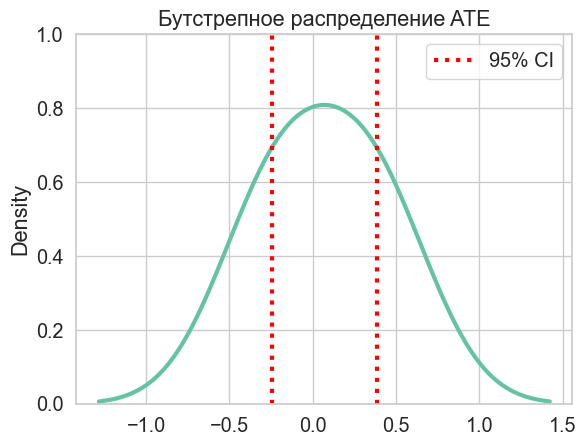

In [37]:
sns.kdeplot(ates[0], lw=3)
plt.vlines(np.percentile(ates, [2.5, 97.5]), 0, 25,
           color='red', lw=3, linestyles="dotted", label="95% CI")
plt.title("Бутстрепное распределение ATE")
plt.legend()
plt.ylim((0,1))
plt.show();

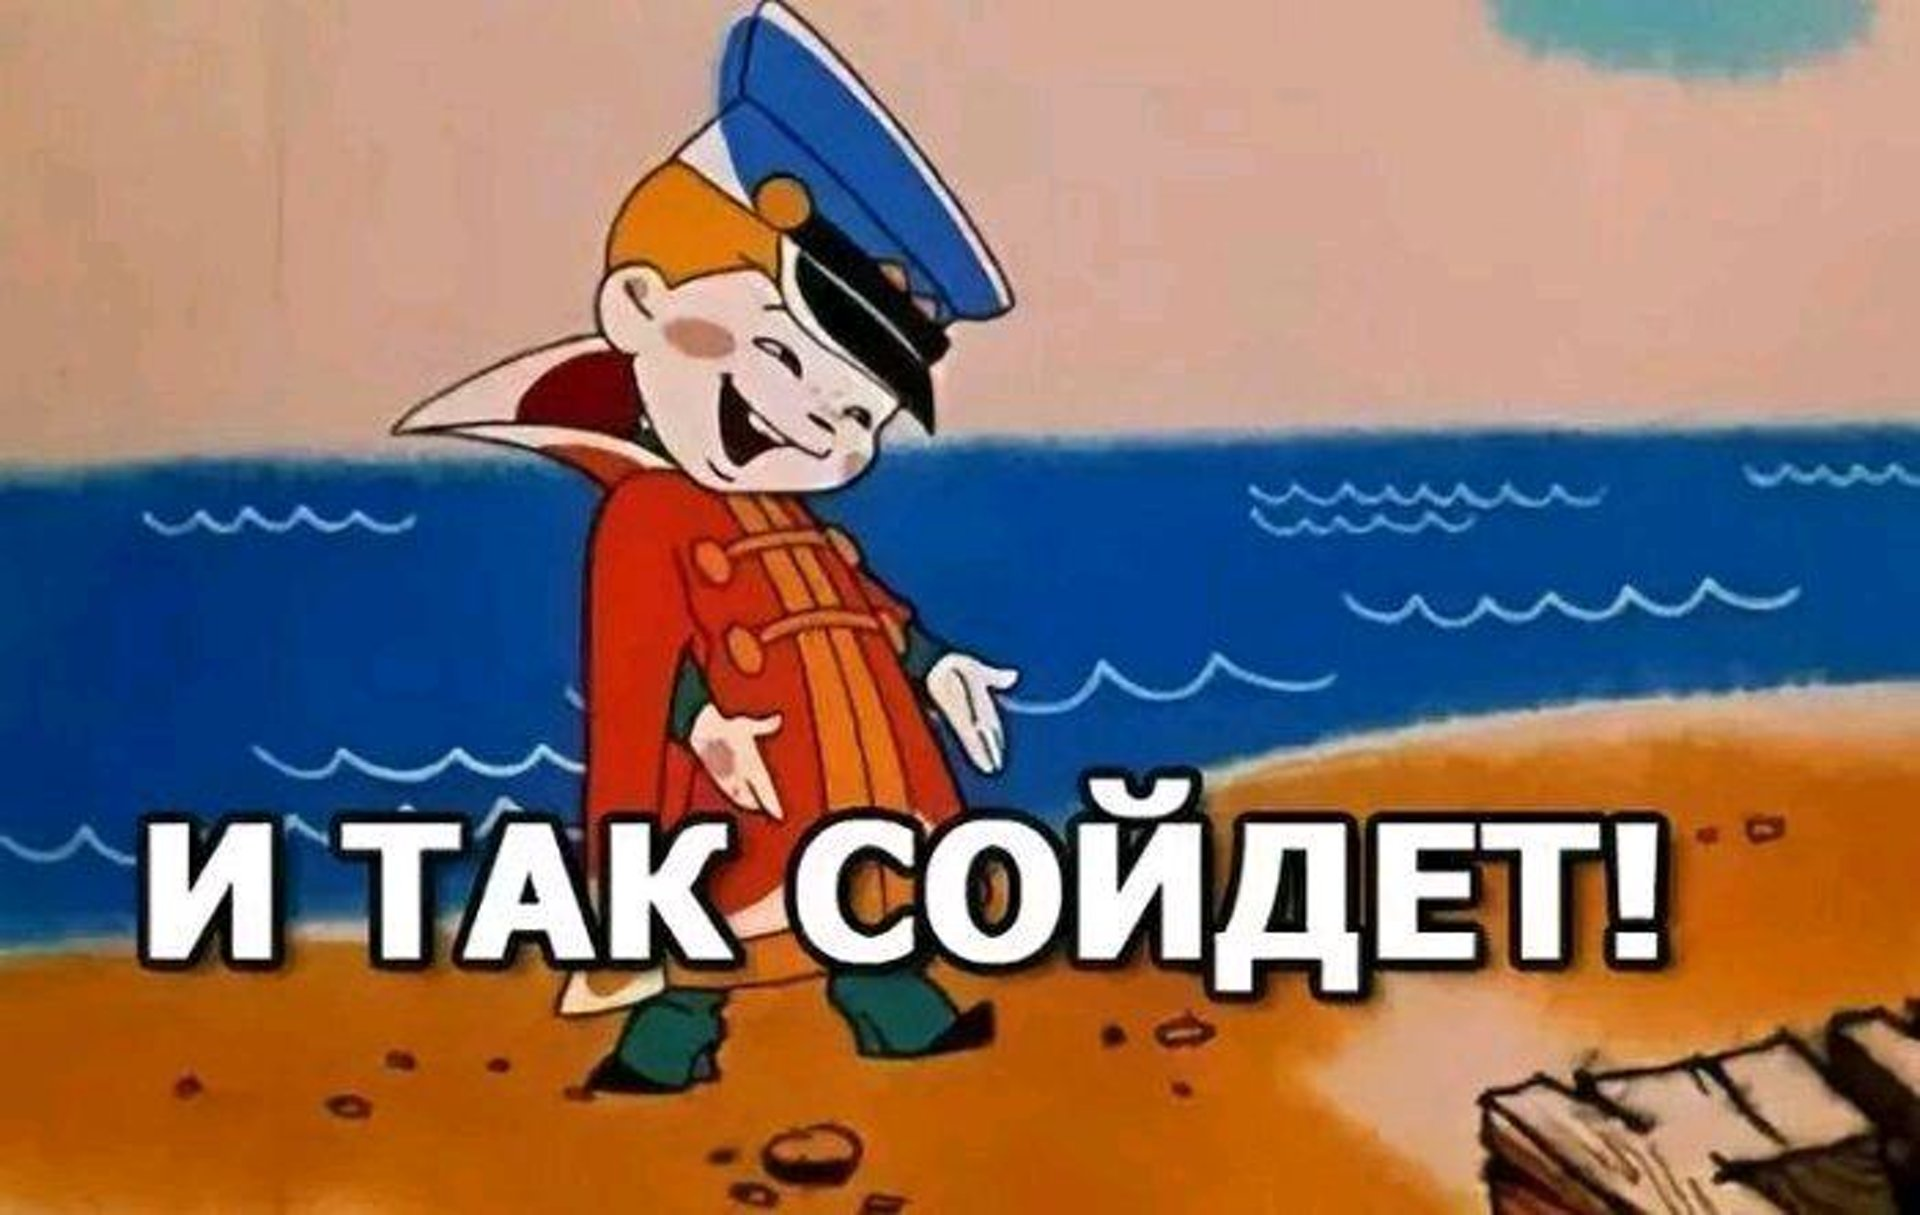

In [38]:
from IPython.display import Image
Image("https://cdn1.flamp.ru/64780ce1ec27b308d068e45fb2eb3527_1920.jpg")

## 4. Особенности работы с Propensity Score

Может возникнуть желание использовать все возможные инструменты машинного обучения, чтобы сделать propensity score максимально точной. Но не стоит все это делать вслепую. Теория о propensity score появилась недавно, и в ней еще многое не изучено.

Однако, можно сказать следующее. Прогнозное качество propensity score не отражается на его уравновешивающих свойствах. **По сравнению с традиционным машинным обучением в причинно-следственном выводе необходимо отказаться от рассмотрения любых задач как задач прогнозирования**. Фактически, минимизация ошибки propensity score может даже навредить цели причинно-следственного вывода. **Propensity score не обязательно должен очень хорошо предсказывать тритмент. Ему просто нужно учесть все конфаундеры.** Если мы будем использовать признаки, которые очень классные для прогнозирования тритмента, но не имеют никакого отношения к результату, это увеличит дисперсию propensity score.

---

Для примера рассмотрим две школы. Одна в 99% случаев назначает тритмент, а другая только в 1% случаев. Причем делают это рандомизировано, поэтому нет необходимости что-либо контролировать дополнительно.

Если добавить признак `school` в модель propensity score, она будет обладать очень высокой прогнозной способностью. Однако, в итоге получим выборку, в которой все в школе А проходят семинар, что приводит к огромной дисперсии.

*Отметим, что в этом примере истинный эффект равен 0.1*

In [ ]:
np.random.seed(42)
school_a = pd.DataFrame(dict(T=np.random.binomial(1, 0.99, 400), school=0, intercept=1))
school_b = pd.DataFrame(dict(T=np.random.binomial(1, 0.01, 400), school=1, intercept=1))

ex_data = pd.concat([school_a, school_b])
ex_data['y'] = np.random.normal(1 +  0.1*ex_data["T"])
ex_data.head()

Проведем бутстреп по двум моделям. Первая использует `school` как признак, вторая обучает константу.

In [ ]:
%%time

ate_w_f =  Parallel(n_jobs=4) (
    delayed(run_ps) (ex_data.sample(frac=1, replace=True), ["school"], "T", "y")
    for _ in range(bootstrap_sample)
)
ate_w_f = np.array(ate_w_f)


ate_wo_f =  Parallel(n_jobs=4) (
    delayed(run_ps) (ex_data.sample(frac=1, replace=True), ["intercept"], "T", "y")
    for _ in range(bootstrap_sample)
)
ate_wo_f = np.array(ate_wo_f)

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(ate_w_f, label="C доп. признаком")
sns.histplot(ate_wo_f, label="Без доп. признака")
plt.legend()
plt.subplot(122)
sns.kdeplot(ate_w_f, lw=3, common_norm=False, label="C доп. признаком")
sns.kdeplot(ate_wo_f, lw=3, common_norm=False, label="Без доп. признака")
plt.legend()
plt.suptitle("Сравнение двух моделей оценки propensity score")
plt.show();

По графику видим, что
* оценка propensity score без признака `school` несмещенная и обладает небольшой дисперсией,
* оценка propensity score с признаком `school` смещенная и обладает большой дисперсией.

---

Не редко, когда данные сильно не сбалансированы, можно наблюдать следующую ситуацию. Для большого количества объектов здесь вообще нет сопоставимых. В таком случае можно обрезать выборку на основне propensity score. Эмпирическое правило &mdash; удалять тех, у кого вес не меньше 20.

In [ ]:
ps_test = np.random.beta(4, 1, 500)
ps_control = np.random.beta(1, 3, 500)

plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(ps_test, label="Тест")
sns.histplot(ps_control, label="Контроль")
plt.subplot(122)
sns.kdeplot(ps_test, lw=3, common_norm=False, label="Тест")
sns.kdeplot(ps_control, lw=3, common_norm=False, label="Контроль")
plt.suptitle("Проверка на сопоставимость")
plt.show();

### Propensity Score Matching

Можно также использовать propensity score как признак для линейной регрессии. Тем самым будет производится матчинг по propensity score

In [ ]:
smf.ols(
    "achievement_score ~ intervention + propensity_score", data=data_ps
).fit().summary().tables[1]

# 2. Doubly Robust Estimation

Что мы уже узнали для оценки причинно-следственного эффекта?
* Построение модели линейной регрессии с учетом некоторых признаков.
* Построение propensity score для взвешивания или матчинга.

Какую из этих моделей использовать на практике? Ведь как одна, так и другая могут ошибаться. Оказывается, можно их скомбинировать таким способом, что результат будет верным как минимум в том случае, если верна хотя бы одна из моделей. Получаемая оценка ATE называется *оценкой с двойной надежностью* или doubly robust estimation.


---

Возьмем данные об исследовании семинаров о Growth Mindset, а также вспомним наш граф, который привел нас к propensity score

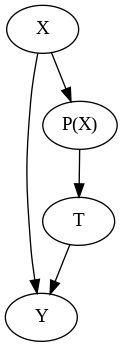


## Doubly Robust Estimation

Знакомьтесь:

$$
\widehat{ATE} = \frac{1}{n}\sum_{i=1}^n \bigg( \dfrac{T_i \left(Y_i - \widehat{\mu}_1(X_i)\right)}{\widehat{P}(X_i)} + \widehat{\mu}_1(X_i) \bigg) - \frac{1}{n}\sum_{i=1}^n \bigg( \dfrac{(1-T_i)\left(Y_i - \widehat{\mu}_0(X_i)\right)}{1-\widehat{P}(X_i)} + \widehat{\mu}_0(X_i) \bigg),
$$

где
* $\widehat{P}(x)$ &mdash; оценка propensity score (напр., логистическая регрессия);
* $\widehat{\mu}_1(x)$ &mdash; оценка $\mathsf{E}(Y|X, T=1)$ (напр., линейная регрессия);
* $\widehat{\mu}_0(x)$ &mdash; оценка $\mathsf{E}(Y|X, T=0)$ (напр., линейная регрессия).

Слагаемые в формуле выше оценивают $\mathsf{E} C_1$ и $\mathsf{E} C_0$ соответственно.


In [ ]:
def doubly_robust(df, X, T, Y):
    '''
    Оценка ATE с двойной надежностью.

    * df -- таблица данных
    * X -- список имен столбцов конфаундеров
    * T -- имя тритмента
    * Y -- имя таргета
    '''

    # Оцениваем propensity score для всех объектов
    lr_model = LogisticRegression(C=1e6, max_iter=1000)
    lr_model.fit(df[X], df[T])
    propensity_score = lr_model.predict_proba(df[X])[:, 1]

    # Оцениваем E(Y|X, T=0) для всех объектов
    mu0 = LinearRegression().fit(
        df.query(f"{T}==0")[X],
        df.query(f"{T}==0")[Y]
    ).predict(df[X])

    # Оцениваем E(Y|X, T=1) для всех объектов
    mu1 = LinearRegression().fit(
        df.query(f"{T}==1")[X],
        df.query(f"{T}==1")[Y]
    ).predict(df[X])

    # Оцениваем E С_1 и E C_0
    mean_c1 = np.mean(df[T]*(df[Y] - mu1)/propensity_score + mu1)
    mean_c0 = np.mean((1-df[T])*(df[Y] - mu0)/(1-propensity_score) + mu0)

    # Итоговая оценка ATE
    return mean_c1 - mean_c0

In [ ]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

doubly_robust(data_with_categ, X, T, Y)

**ВЫВОД** <...>


Аналогично, можно использовать бутстреп для получения доверительных интервалов

---

Наконец, убедимся в двойной надежности оценки, а именно, почему для ее корректности требуется корректность (несмещенность) только одной из моделей.

Проверим на практике данное утверждение. Для начала заменим лог. регрессию для оценки propensity score случайными числами

In [ ]:
def doubly_robust_wrong_ps(df, X, T, Y):
    '''
    Оценка ATE с двойной надежностью с НЕКОРРЕКТНОЙ propensity score.

    * df -- таблица данных
    * X -- список имен столбцов конфаундеров
    * T -- имя тритмента
    * Y -- имя таргета
    '''

    # Генерируем propensity score для всех объектов
    propensity_score = np.random.uniform(0.1, 0.9, df.shape[0])

    # Оцениваем E(Y|X, T=0) для всех объектов
    mu0 = LinearRegression().fit(
        df.query(f"{T}==0")[X],
        df.query(f"{T}==0")[Y]
    ).predict(df[X])

    # Оцениваем E(Y|X, T=1) для всех объектов
    mu1 = LinearRegression().fit(
        df.query(f"{T}==1")[X],
        df.query(f"{T}==1")[Y]
    ).predict(df[X])

    # Оцениваем E С_1 и E C_0
    mean_c1 = np.mean(df[T]*(df[Y] - mu1)/propensity_score + mu1)
    mean_c0 = np.mean((1-df[T])*(df[Y] - mu0)/(1-propensity_score) + mu0)

    # Итоговая оценка ATE
    return mean_c1 - mean_c0

In [ ]:
doubly_robust_wrong_ps(data_with_categ, X, T, Y)

Теперь рассмотрим другую ситуацию. Линейные регрессии заменим случайными числами

In [ ]:
def doubly_robust_wrong_model(df, X, T, Y):
    '''
    Оценка ATE с двойной надежностью с НЕКОРРЕКТНЫМИ моделями лин. регрессии.

    * df -- таблица данных
    * X -- список имен столбцов конфаундеров
    * T -- имя тритмента
    * Y -- имя таргета
    '''

    # Генерируем propensity score для всех объектов
    lr_model = LogisticRegression(C=1e6, max_iter=1000)
    lr_model.fit(df[X], df[T])
    propensity_score = lr_model.predict_proba(df[X])[:, 1]

    # Генерируем E(Y|X, T=0) для всех объектов
    mu0 = np.random.normal(0, 1, df.shape[0])

    # Генерируем E(Y|X, T=1) для всех объектов
    mu1 = np.random.normal(0, 1, df.shape[0])

    # Оцениваем E С_1 и E C_0
    mean_c1 = np.mean(df[T]*(df[Y] - mu1)/propensity_score + mu1)
    mean_c0 = np.mean((1-df[T])*(df[Y] - mu0)/(1-propensity_score) + mu0)

    # Итоговая оценка ATE
    return mean_c1 - mean_c0

In [ ]:
doubly_robust_wrong_model(data_with_categ, X, T, Y)


**Вывод**